# Standard Setup

### Imports 

In [1]:
# Standard things
import math
import numpy as np
import jax.numpy as jnp
import jax

# FLOAT64 seems to be necessary for integral precision
jax.config.update("jax_enable_x64", True)

# Project-specific things
# from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
# from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs
# from utils.distribution_utils import construct_pdf, construct_cdf

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs, build_powers
from utils.distribution_utils import q, log_q

from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors
import matplotlib as mpl


### Jax setting and compilation

In [2]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_log_q  = jax.jit(log_q)
vmapped_log_q = jax.vmap(jitted_log_q, in_axes=(0, None, None, None))

jitted_polynomial = jax.jit(polynomial)
vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

# Problem Setup

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


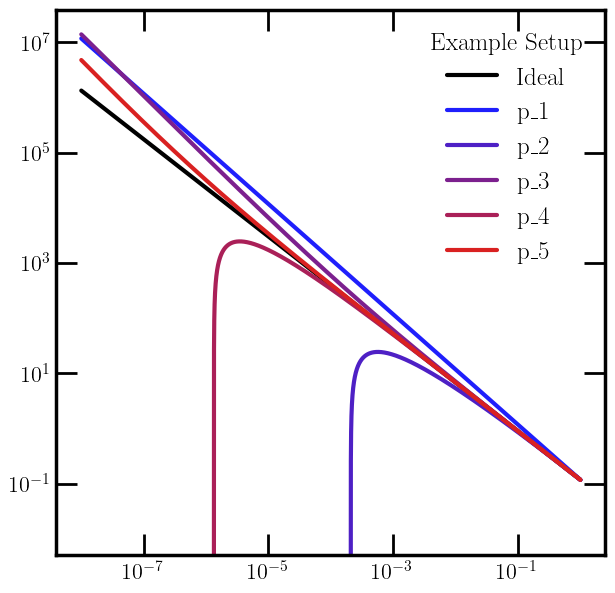

In [3]:
max_order = 5
num_trials = 100
extra_orders = 1

ALT_DATASET = False



# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)



def exponential_distribution(t, alpha, params):
    return alpha  * jnp.exp(-alpha * t)


def p_order_N(t, alpha, M):

    result = jnp.zeros_like(t)
    for i in range(M ):
        result += alpha * jnp.power(-1 * alpha * t , i) / math.factorial(i)
    return result


# Colormap setup
colors = [0]
for order in range(1,max_order+1):

    o = (order) / (max_order)
    colors.append((o, 0, 1 - o))


colors = ["#000000","#61aed1", "#618dd1", "#a161d1", "#d16196", "#d16163"]
colors = ["#000000", "#1F1FFC", "#4E20C5", "#7C208E", "#AA2058", "#D92121"]

# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, exponential_distribution(t_from_x(xs) , 0.118, None) / xs, label="Ideal", color = "black")
for order in range(1,max_order+1):
    ax.plot(xs, p_order_N(t_from_x(xs), 0.118, order) / xs, label=f"p_{order}", color = colors[order])

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





### Alternate Problem: Angularity-like

In [4]:

if ALT_DATASET:

    def exponential_distribution(t, alpha, params):

        # scale = 91.1876 * x_from_t(t)
        # L = jnp.log(scale / mz)
        # alpha_bar = running_coupling(alpha, mz, scale)

        alpha_bar = alpha * 4/3 / jnp.pi

        beta_0 = (11 * 3 - 2 * 5) / (12 * jnp.pi)

        # integral = jnp.log( 1 - 2 * alpha_bar * jnp.pi / 4 * 3 * beta_0 * L) / (2 * beta_0)
        integral = alpha_bar * t * t / 2

        return alpha_bar * t * jnp.exp(-integral) 


    def p_order_N(t, alpha, M):

        # scale = 91.1876 * x_from_t(t)
        # alpha_bar = running_coupling(alpha, mz, scale)


        result = 0
        alpha_bar = alpha * 4/3 / jnp.pi
        for i in range(M ):
            result += alpha_bar * t * jnp.power(-1 * alpha_bar * t **2 / 2, i) / math.factorial(i)
        return result


    # Plot
    xs = jnp.logspace(-8, 0, 10000)

    fig, ax = newplot("full")
    ax.plot(xs, exponential_distribution(t_from_x(xs) , 0.118, None) / xs, label="Ideal", color = "black")
    for order in range(1,max_order+1):
        ax.plot(xs, p_order_N(t_from_x(xs), 0.118, order) / xs, label=r"$\mathcal{O}(\alpha"  + f"^{order})", color = colors[order])

    # ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$p(x|\alpha)$")

    plt.legend(title = "Example Setup")

    fig, ax = newplot("full")
    ax.plot(t_from_x(xs), exponential_distribution(t_from_x(xs) , 0.118, None), label="Ideal", color = "black")
    for order in range(1,max_order+1):
        ax.plot(t_from_x(xs), p_order_N(t_from_x(xs), 0.118, order), label=f"p_{order}", color = colors[order])

    # ax.set_xscale("log")
    ax.set_yscale("log")
    plt.ylim(1e-3, 1)



# Matching

In [5]:
t = jnp.linspace(0.001, 20, 1000)
xs = x_from_t(t)



# Array to save curves for plotting
data = np.zeros((max_order+1, t.shape[0], num_trials))

for order in range(1, max_order+1):

    def p_temp(t, alpha, params):
        return p_order_N(t, alpha, order)


    m_order = order
    n_order = 1 * order

    # Normalization array, size includes extra orders
    factorials = np.zeros((m_order + 1 + extra_orders, n_order + 1 + extra_orders))
    for i in range(factorials.shape[0]):
        for j in range(factorials.shape[1]):
            factorials[i, j] =  math.factorial(i) #* math.factorial(j)


    # Actually perform the matching
    print("Order: ", order)
    g_mn_matched, g_star = matching_coeffs(p_temp, m_order, n_order)

    print("g_mn_matched: ")
    print(g_mn_matched)
    print("g_star: ")
    print(g_star)


    for trial in range(num_trials):


        # Get a random seed
        seed = jax.random.PRNGKey(trial * 1000 + order * 100) 

        # print(g_mn_matched)
        # print(g_star)
    
        # Prior on the g_mn
        std =  0.1 / factorials
        g_mn = (2 * (jax.random.uniform(seed, factorials.shape))-1)   * std  #- (std**2 / 2)
        max_m = g_mn.shape[0]
        max_n = g_mn.shape[1]




        # set the highest order term to be negative
        g_mn = g_mn.at[order+1:max_m, max_n-1].set(-jnp.abs(g_mn[order+1:max_m, max_n-1]))

        # Set the coefficients of the random array to be the matched ones
        g_mn = g_mn.at[:m_order+1, :].set(0)
        g_mn = g_mn.at[:m_order+1, :n_order+1].set(g_mn_matched)


        # Save the curve
        data[order, :, trial] = jnp.nan_to_num(vmapped_q(t, 0.118, g_star, g_mn))[:,0]



Order:  1


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


g_mn_matched: 
[[0. 0.]
 [0. 0.]]
g_star: 
[[ 0.  0.]
 [-1.  0.]]
Order:  2


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


g_mn_matched: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
g_star: 
[[ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]
Order:  3
g_mn_matched: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
Order:  4
g_mn_matched: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Order:  5
g_mn_matched: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


# Aesthetic Setup

In [6]:
all_colors = colors[1:max_order+1] + ["black"]
cmap = mpl.colors.ListedColormap(all_colors)

bounds = np.arange(1, max_order + 3) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

tick_locs = np.arange(1.75, max_order + 2.75)
tick_labels = [r"$\mathcal{O}(\alpha_s^{%d})$" % k for k in range(1, max_order+1)]
tick_labels.append(r"Truth")  # last bin


sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


name = "Exponential" if not ALT_DATASET else "Rayleigh"

### Plots

Integral:  0.9054622048200445
Order 1
0.9164268347990081
0.9207509721133051
0.9092695082002455
0.9059539084541963
0.9100644717251131
0.9050394867441799
0.9211512703860885
0.908468136258531
0.920372893386816
0.9115258142492424
0.915247729011826
0.9208412706822048
0.9207828677897223
0.9163408315939141
0.9072959895653857
0.9208962728707126
0.9200841460107936
0.9095565208990577
0.9207394066885235
0.9239437935437731
0.9209894033333621
0.9049459809884461
0.9103335571142144
0.910118728743806
0.9254167613703305
0.9163530600578667
0.9057517133078212
0.9160942794290896
0.9154144059573384
0.9171577175066894
0.917892464754361
0.9097393514165458
0.9225125907721436
0.9181558807514404
0.9237786283245311
0.911919720454673
0.9173386864084071
0.9148936656264368
0.9135997908160386
0.9112139482883141
0.908392058801885
0.9204812451157465
0.9143866065554729
0.9186546547645014
0.9137554378839968
0.9109977852734298
0.9206847433927277
0.9201567070984376
0.9097154752636042
0.9166891789189381
0.9122760658898923


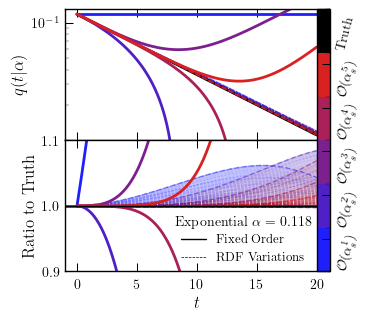

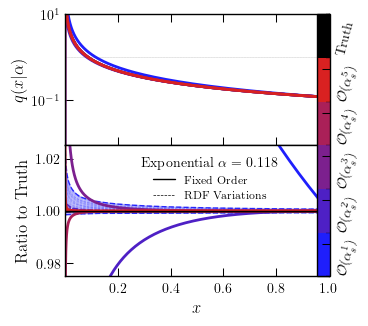

In [7]:
fig, ax = newplot("column", subplot_array=(2, 1), sharex=True)


ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black", lw = 2)

ys = exponential_distribution(t, 0.118, None)
print("Integral: ", jnp.trapz(ys, t))



for order in range(1, max_order+1):
    ax[0].plot(t, p_order_N(t, 0.118, order), label=f"Order {order}", color = colors[order],lw = 2)



    mean = np.nanmean(data[order], axis = 1)
    # std = np.nanstd(data[order], axis = 1)
    plus = np.nanmax(data[order], axis = 1)
    minus = np.nanmin(data[order], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(t, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(t, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(t, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(t, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(t, (minus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(t, (plus) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(t, (minus) / exponential_distribution(t, 0.118, None), (plus) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    


    for trial in range(num_trials):

        ax[0].plot(t, data[order, :,trial], color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)




    ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],lw=2)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 1)



# ax[0].legend(loc = "lower left", ncol = 2)
cbar = fig.colorbar(
    sm,
    ax=ax,                 # apply to the whole subplot group
    ticks=tick_locs,
    boundaries=bounds,
    spacing='proportional',
    pad = 0.5,
    anchor = (1.05, 0.5),
)

cbar.ax.set_yticklabels(tick_labels, rotation = 75)
# cbar.set_label("Order", rotation=90)



true_handle1 = mpl.lines.Line2D([], [], color="black", lw=1, label="Fixed Order")
true_handle2 = mpl.lines.Line2D([], [], color="black", ls = "--", lw=0.5, label="RDF Variations")

if not ALT_DATASET:
    ax[1].legend(handles=[true_handle1, true_handle2], loc="lower right", title = f" {name} " + r"$\alpha = 0.118 $ " + "\t", frameon=False,  ncol = 1, fontsize = 9, title_fontsize = 10, bbox_to_anchor=[0.975, -0.025])
else:
    ax[1].legend(handles=[true_handle1, true_handle2], loc="upper right", title = f" {name} " + r"$\alpha = 0.118 $ " + "\t", frameon=False,  ncol = 1, fontsize = 8, title_fontsize = 10, bbox_to_anchor=[0.9, 1.025])

ax[0].set_yscale("log")
# ax[1].set_yscale("log")

ax[1].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$q(t|\alpha)$")
ax[1].set_ylabel("Ratio to Truth")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.00)

max_y = 1.1 * np.max(exponential_distribution(t[1:], 0.118, None))
min_y = 0.9 * np.min(exponential_distribution(t[1:], 0.118, None))
ax[0].set_ylim(min_y, max_y)
ax[1].set_ylim(0.90, 1.1)


# Hide x tick labels on the top panel to avoid overlap
ax[0].tick_params(labelbottom=False)


plt.savefig(f"plots/{name}_t.pdf", bbox_inches='tight')


# ######################### X version #########################

fig, ax = newplot("column", subplot_array=(2, 1), sharex=True)

xs = x_from_t(t)

ax[0].plot(xs, exponential_distribution(t, 0.118, None)/ xs, label="True", color = "Black", lw = 2)


# set ax[0] to take up the whole space

for order in range(1, max_order+1):

    print("Order" , order)

    ax[0].plot(xs, p_order_N(t, 0.118, order) / xs, label=f"Order {order}", color = colors[order],lw = 2)



    for trial in range(num_trials):

        ax[0].plot(xs, data[order, :,trial] / xs , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(xs, data[order, :,trial] / exponential_distribution(t, 0.118, None) , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)

        integral = jnp.trapz(data[order, :,trial], t)
        # print(data[order, :,trial])
        print(integral)



    mean = np.nanmean(data[order], axis = 1) / xs
    plus = np.nanmax(data[order], axis = 1) / xs
    minus = np.nanmin(data[order], axis = 1) / xs


    std = np.nanstd(data[order], axis = 1) / xs

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(xs, plus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(xs, minus, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(xs, minus, plus, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(xs, minus, plus, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.95, lw = 1)
    ax[1].plot(xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.95, lw = 1)
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None) * xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(xs, (minus) / exponential_distribution(t, 0.118, None)* xs, (plus) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], alpha = 0.25, ls = "--")


    ax[1].plot(xs, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order], lw = 2)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 1)


# Add shaded to legend
ax[0].fill_between(xs, np.ones_like(xs), np.ones_like(xs), color = "grey", alpha = 0.99, ls = "--", label = "Matched", lw = 0.1)




# ax[0].legend(loc = "lower left", ncol = 2)
cbar = fig.colorbar(
    sm,
    ax=ax,                 # apply to the whole subplot group
    ticks=tick_locs,
    boundaries=bounds,
    spacing='proportional',
    pad = 0.5,
    anchor = (1.05, 0.5),
)

cbar.ax.set_yticklabels(tick_labels, rotation = 75)
# cbar.set_label("Order", rotation=90)



true_handle1 = mpl.lines.Line2D([], [], color="black", lw=1, label="Fixed Order")
true_handle2 = mpl.lines.Line2D([], [], color="black", ls = "--", lw=0.5, label="RDF Variations")

loc = "lower" if not ALT_DATASET else "upper"
if not ALT_DATASET:
    ax[1].legend(handles=[true_handle1, true_handle2], loc=f"{loc} left", title = r" Exponential $\alpha = 0.118 $ " + "\t", frameon=False,  ncol = 1, fontsize = 8, title_fontsize = 10, bbox_to_anchor=[0.25, 0.5])
else:
    ax[1].legend(handles=[true_handle1, true_handle2], loc=f"{loc} right", title = r" Rayleigh $\alpha = 0.118 $ " + "\t", frameon=False,  ncol = 1, fontsize = 8, title_fontsize = 10, bbox_to_anchor=[0.9, .45])

ax[1].tick_params(top=False)

ax[0].set_yscale("log")
# ax[1].set_yscale("log")
# ax[0].set_xscale("log")

ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$q(x|\alpha)$")
ax[1].set_ylabel("Ratio to Truth")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.00)

ax[1].set_xlim(1e-9, 1)
ax[0].set_ylim(9e-3, 1e1)
ax[1].set_ylim(0.975, 1.025)


# Hide x tick labels on the top panel to avoid overlap
ax[0].tick_params(labelbottom=False)


plt.savefig(f"plots/{name}_x.pdf", bbox_inches='tight')


# fig.delaxes(ax[1])
# # set ax[0] height 
# fig.set_figheight(12)

# Parameter Extraction

### Define the Dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


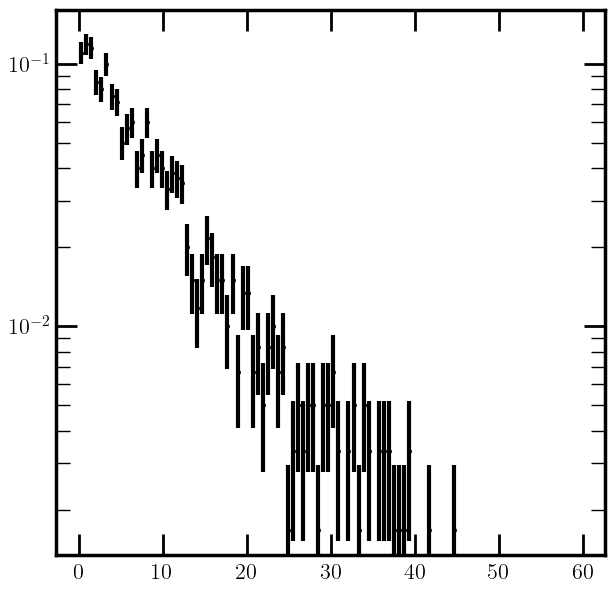

In [8]:
N_data = 1000
alpha_true = 0.118
t_max = 60

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true





# ########## Alternate Dataset ##########

def sample_from_rayleigh(seed, alpha, shape=(1,)):

    alpha_bar = alpha * 4/3 / jnp.pi
    u = jax.random.uniform(seed, shape=shape)
    scale = 1.0 / jnp.sqrt(alpha_bar)
    t = scale * jnp.sqrt(-2.0 * jnp.log(u))
    return t

# Usage:
if ALT_DATASET:
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_rayleigh(seed, alpha_true, shape=(N_data,))
    t_max = 15
    print("Mean of samples:", jnp.mean(t_data))





fig, ax = newplot("full")
bins = 100
counts, bins = np.histogram(t_data, bins = 100, range = [0, t_max], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)

plt.legend()

plt.yscale("log")

### Attempt MLE with the Fixed Order

Text(0, 0.5, '$-2 \\log L(\\alpha)$')

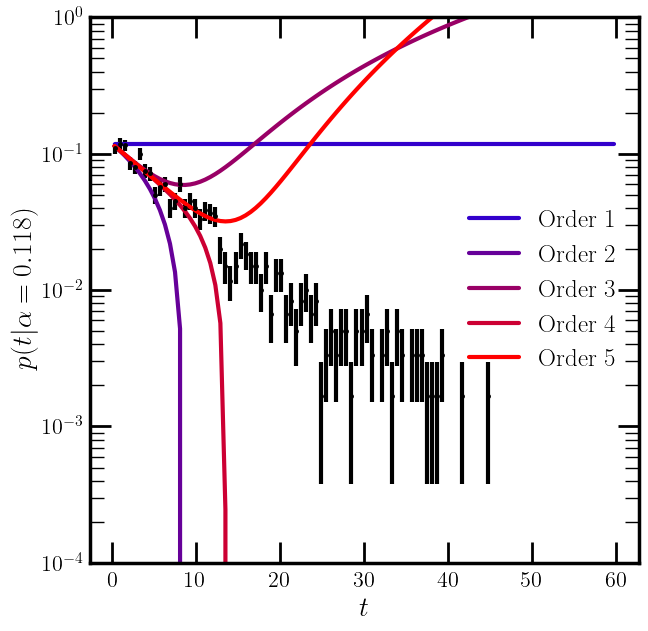

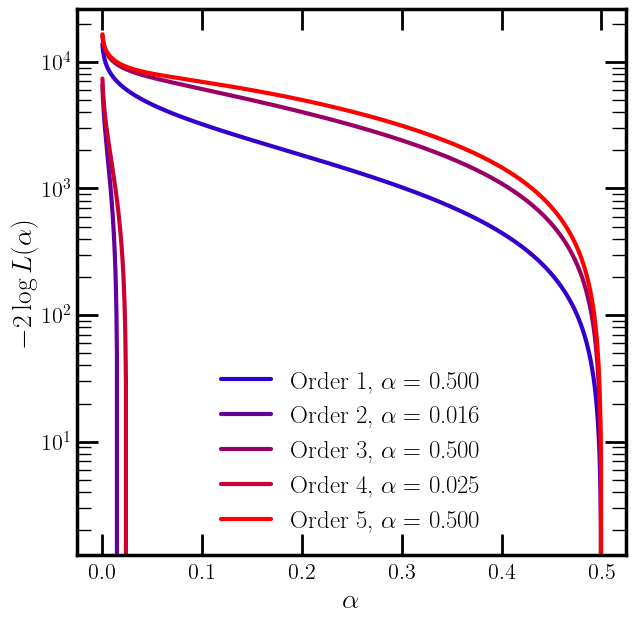

In [9]:
# Get lambda functions for FO likelihoods




max_M = 5


fig, ax = newplot("full")
bins = 100
counts, bins = np.histogram(t_data, bins = 100, range = [0, t_max], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)


for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")

plt.xlabel(r"$t$")
plt.ylabel(r"$p(t|\alpha = 0.118)$")

plt.ylim(1e-4, 1e0)

plt.legend()


fig, ax = newplot("full")                                                                       
for i in range(1, max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}, " + r"$\alpha = $" +  f"{best_alpha : .3f}", color = color)

plt.legend()
plt.yscale("log")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-2 \log L(\alpha)$")


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


g_mn_matched: 
[[0. 0.]
 [0. 0.]]
g_star: 
[[ 0.  0.]
 [-1.  0.]]
Order 1
Full Min 6140.223839107815
Full Alpha 0.12207771994776495
Full Coeffs [ 7.93744740e-08 -8.46958782e-06  0.00000000e+00]


0it [00:00, ?it/s]

alpha Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> L Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


1001it [00:05, 172.10it/s]


Order 1
Min Alpha 0.1221
Range 0.11825 0.12594999999999998
Coeffs [ 2.06662155e-05 -8.46958782e-06  0.00000000e+00]


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


g_mn_matched: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
g_star: 
[[ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]
Order 2
Full Min 6110.225028240135
Full Alpha 0.1212432136369481
Full Coeffs [ 4.53992397e-07  1.96090474e-07 -1.33925760e-07  0.00000000e+00]


0it [00:00, ?it/s]

alpha Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> L Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


1001it [00:07, 126.85it/s]


Order 2
Min Alpha 0.12125
Range 0.1174 0.12505
Coeffs [ 4.53992397e-07  3.52150318e-07 -2.52536994e-07  0.00000000e+00]
g_mn_matched: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
Order 3
Full Min 6070.983240147665
Full Alpha 0.12012383354908901
Full Coeffs [-3.89518579e-08  3.53778115e-08 -1.01901214e-08 -1.84795074e-09
  0.00000000e+00]


0it [00:00, ?it/s]

alpha Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> L Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


1001it [00:10, 95.98it/s] 


Order 3
Min Alpha 0.1201
Range 0.11635000000000001 0.12395
Coeffs [-3.89518579e-08  3.53778115e-08 -1.01901214e-08 -2.70459251e-08
  0.00000000e+00]
g_mn_matched: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Order 4
Full Min 6022.386403110857
Full Alpha 0.11876676170337802
Full Coeffs [ 3.47929048e-09  4.43642679e-09 -1.78971138e-09 -3.45263942e-09
 -1.02529769e-09  0.00000000e+00]


0it [00:00, ?it/s]

alpha Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> L Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


1001it [00:09, 102.46it/s]


Order 4
Min Alpha 0.11875
Range 0.11499999999999999 0.12254999999999999
Coeffs [ 3.47929048e-09  4.43642679e-09 -1.78971138e-09 -3.45263942e-09
 -7.95793781e-09  0.00000000e+00]
g_mn_matched: 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
g_star: 
[[ 0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
Order 5
Full Min 5964.295067232296
Full Alpha 0.11715662978423975
Full Coeffs [ 1.80969961e-10 -3.53716228e-11 -7.62803165e-11  1.66361359e-10
 -5.16249525e-10 -6.39442258e-10  0.00000000e+00]


0it [00:00, ?it/s]

alpha Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)> L Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


1001it [00:11, 85.25it/s]


Order 5
Min Alpha 0.11715
Range 0.1134 0.1209
Coeffs [ 1.80969961e-10 -3.53716228e-11 -7.62803165e-11  1.66361359e-10
 -5.16249525e-10 -1.32935453e-09  0.00000000e+00]


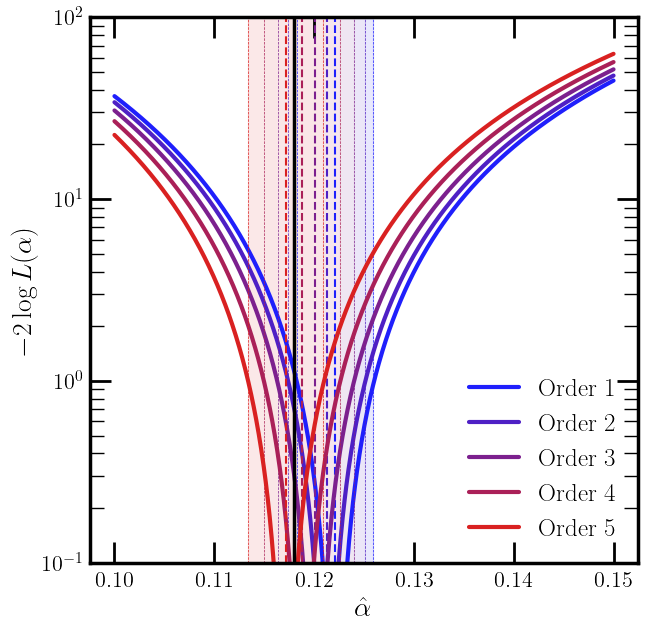

In [10]:
from scipy.optimize import minimize
from tqdm import tqdm

# Only 1 higher order term works for now
num_higher_orders = 1

# highest order to try
max_M = 5


fig, ax = newplot("full")           

alpha_low = 0.1
alpha_high = 0.15
num_alpha_points = 1001

likelihood_data = np.zeros((max_M, num_alpha_points))
g_mn_data = []




def log_prior(g_mn_higher, m, alpha):

    beta0 = 11/3*3 - 5 * 2/3 
    std = 0.1 / math.factorial(m) #10*(alpha * jnp.log(2) * beta0 / (2 * jnp.pi))**m

    std = 1 * (alpha * jnp.log(2) * beta0 / (2 * jnp.pi))**m

    # treat the higher order terms as a gaussian prior
    return jnp.sum(jnp.log(jax.scipy.stats.norm.pdf(g_mn_higher, 0, std)))


for i in range(1,max_M + 1):

    g_mn_data_i = []

    # Initialize g_mn by matching the low order stuff
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    
    # @RIKAB CHANGE BACK, JUST A TEST
    g_mn_matched = jnp.zeros_like(g_mn_matched)


    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

    print("g_mn_matched: ")
    print(g_mn_matched)
    print("g_star: ")
    print(g_star)

    # Data cutoff
    masked_data = t_data[t_data < 60]

    # Likelihood function, params[0] = alpha, params[1:] = higher order g_mn
    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]
        highest_order = g_mn_higher.shape[0]

        # Set g so that the lower order terms are matched and the higher order terms are the ones we are varying
        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)

        L =  -2 * jnp.sum((vmapped_log_q(masked_data, alpha, g_star, g_mn)))
        L = L - 2*log_prior(g_mn_higher, highest_order, alpha)
        return L
    
    # Profile likelihood whe alpha is a parameter and g_mn_higher is varied
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):


        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)
        g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
        highest_order = g_mn_higher.shape[0]

        L =  -2 * jnp.sum((vmapped_log_q(masked_data, alpha, g_star, g_mn)))
        L = L - 2*log_prior(g_mn_higher, highest_order, alpha)

        print("alpha", alpha, "L", L)

        return L
    
    

    ###### Minimize likelihood function #####
    # This is the denominator of the profile likelihood ratio

    # Initial guess: alpha = 0.118, g_mn = 0
    initial_alpha = 0.118
    initial_guess = jnp.zeros(g_mn.shape[1]+1)
    initial_guess = initial_guess.at[0].set(initial_alpha)

    # Minimize the full likelihood to et the best alpha and g_mn
    bounds = [(alpha_low, alpha_high)] + [(None, None)] * g_mn.shape[1]
    bounds[-1] = (None, 0) # Set the last g_mn to be negative
    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False}, bounds=bounds)

    print("Order", i)
    print("Full Min", res_full.fun)
    print("Full Alpha", res_full.x[0])
    print("Full Coeffs", res_full.x[1:])



    ###### Minimize profile likelihood function #####

    # Scan over alpha
    central_alpha = res_full.x[0]
    alphas = jnp.linspace(alpha_low, alpha_high , num_alpha_points)

    # Minimize for each alpha, using the g_mn from the full minimization as a starting point
    def profile_minimize(alphas, next_x):


        # o = profile_likelihood_function(jnp.zeros_like(next_x), alphas)
        # return o, next_x
        bounds = [(None, None)] * next_x.shape[0]
        bounds[-1] = (None, 0) # Set the last g_mn to be negative
        res_partial = minimize(profile_likelihood_function, next_x, args=(alphas), method='Nelder-Mead', options={'disp': False, 'maxiter': 1000}, bounds=bounds)
        
        # print(alphas, res_partial.fun, res_partial.x)
        return res_partial.fun, res_partial.x

    likelihoods = jnp.zeros(alphas.shape)
    next_x = res_full.x[1:]
    for j, alpha in tqdm(enumerate(alphas)):
        res_partial, next_x = profile_minimize(alpha, next_x)
        likelihoods = likelihoods.at[j].set(res_partial)
        g_mn_data_i.append(next_x)

    # Subtract the minimum of the full likelihood. Should now have a min of zero
    likelihoods = likelihoods - jnp.min(likelihoods)

    # Save the likelihoods
    likelihood_data[i-1] = likelihoods
    g_mn_data.append(g_mn_data_i)

    # Plot
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 1.5, color = colors[i])


    # Try to get the +- likelihood band
    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]


    print("Order", i)
    print("Min Alpha", min_alpha)

    try:
        minus_one = alphas_less_than_one[0]
        plus_one = alphas_less_than_one[-2]

        # Vertical band
        ax.axvline(minus_one, linestyle = "--", lw = 0.5, color = colors[i])
        ax.axvline(plus_one, linestyle = "--", lw = 0.5, color = colors[i])
        ax.axvspan(minus_one, plus_one, alpha=0.95, color="white")
        ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])
        print("Range", minus_one, plus_one)

    except:
        print("No range found")

    
    print("Coeffs", g_mn_data_i[-1])


ax.axvline(0.118, linestyle = "-", lw = 2.5, color = "black", zorder = 10)

plt.yscale("log")

plt.xlabel(r"$\hat{\alpha}$")
plt.ylabel(r"$-2 \log L(\alpha)$")
plt.ylim(1e-1, 1e2)
plt.legend()

# Test Debugging


@ Radha, this is unimportant.


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


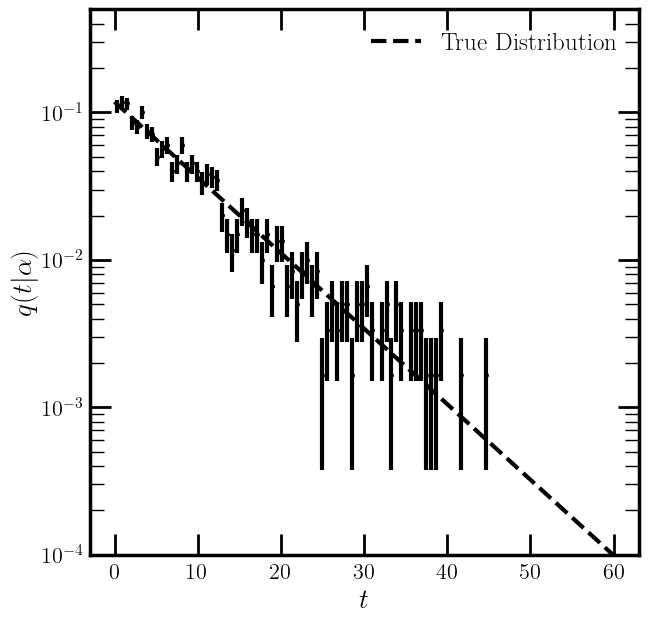

In [11]:
from scipy.optimize import minimize
from tqdm import tqdm


plot_xs = False

ts = jnp.linspace(0, t_max, 1000)
xs = x_from_t(ts)


fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):


    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

    g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
    alphas = jnp.linspace(alpha_low, alpha_high, num_alpha_points)

    for trial in range(num_trials):

        g_mn_higher = g_mn_data[i-1][trial]
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        likelihood = likelihood_data[i-1][trial]
        p_val = np.exp(-likelihood  )

        data0 = vmapped_q(ts, alphas[trial], g_star, g_mn)
     
        if plot_xs:
            ax.plot(xs, data0 / xs, color = colors[i], linestyle = "-", alpha = p_val, lw = 1.5)
        else:
            ax.plot(ts[1:], data0[1:], color = colors[i], linestyle = "-", alpha = p_val, lw = 1.5)





#     # We can only change parameters after the matched order in alpha
#     non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
#     non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)

#     masked_data = t_data[t_data < 30]

#     @jax.jit
#     def likelihood_function(params):

#         alpha = params[0]
#         g_mn_higher = params[1:]

#         g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

#         # print("")
#         # print(g_mn_matched.shape)
#         # print(g_mn.shape)
#         # print(g_mn_higher.shape)

#         g_mn = g_mn.at[:i+1, :i+1].set(g_mn_matched)
#         g_mn = g_mn.at[i+1:, :].set(g_mn_higher)


#         return -2 * jnp.nansum((log_q(masked_data, alpha, g_star, g_mn)))
    

#     # Minimize likelihood function
#     initial_alpha = 0.118
#     initial_guess = jnp.zeros(g_mn.shape[1]+1)
#     initial_guess = initial_guess.at[1:].set(-0.0000 / i )

#     initial_guess = initial_guess.at[0].set(initial_alpha)


#     res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

#     print("Order", i)
#     print("Full Min", res_full.fun)
#     print("Full Alpha", res_full.x[0])
#     print("Full Coeffs", res_full.x[1:])
#     print("Likelihood", -2 * jnp.sum(jnp.log(q(t_data, 0.118, g_star, g_mn_matched))))

#     alpha = 0.118

#     ts = jnp.linspace(0, 50, 1000)
#     g_mn = g_mn.at[:i+1, :].set(0.0)
#     data0 = q(ts, alpha, g_star, g_mn)

#     g_mn = g_mn.at[i+1:, :].set(res_full.x[1:])
#     data1 = q(ts, alpha, g_star, g_mn)

#     ax.plot(ts, data0, label = f"Order {i}", color = colors[i], linestyle = "-")
#     ax.plot(ts, data1, label = f"Order {i} Matched", color = colors[i], linestyle = "--")

# ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

if plot_xs:
    plt.xlabel(r"$x$")
    plt.ylabel(r"$q(x|\alpha)$")
    x_bins = x_from_t(bin_centers)
    plt.errorbar(x_from_t(bin_centers), counts / x_bins, yerr = np.sqrt(counts / N_data) / x_bins, fmt = "o", color = "black",)

    plt.ylim(1e-3, 1e3)
    plt.xscale("log")

else:
    plt.xlabel(r"$t$")
    plt.ylabel(r"$q(t|\alpha)$")


    plt.ylim(1e-4, 5e-1)
    plt.errorbar(bin_centers, counts, yerr = np.sqrt(counts / N_data), fmt = "o", color = "black",)

    plt.plot(ts, exponential_distribution(ts, 0.118, None), label="True Distribution", color = "black", linestyle = "--")

plt.yscale("log")
plt.legend()

